# ISOMAP LAB.2 Solutions

## Exercise 1

First of all let's import the useful modules.

In [1]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt # plotting
import pandas as pd # csv manipulation
from sklearn.model_selection import train_test_split # for train test split
from sklearn.linear_model import LogisticRegression # for classification
from sklearn.neighbors import NearestNeighbors # for nearest neighbors
import numba as nb # speeding up computations
from sklearn.preprocessing import OrdinalEncoder  # for preprocessing


We first implement classical multidimensional scaling as a class.

In [2]:
class MDS(object):
    """
    Perform classical multidimensional scaling. 
    We assume that the returned coordinate matrix have mean 0.
    """
    def __init__(self):
        
        self.eigenvalues = None
        self.eigenvect = None
        self.n_components = None

    def fit(self, X):

        # # check matrix consistency
        # self._check_matrix_consistency(X)

        # get matrix shape
        n = X.shape[0]

        # centering matrix
        C = np.eye(n) - 1./n * np.ones((n, n))

        # double centering matrix
        B = -0.5 * np.dot(C, np.dot(X**2, C))

        # decompose double centering matrix
        eigvalues, eigvects = np.linalg.eigh(B)

        # sort in ascending order + sqrt eigenvalues
        idx = eigvalues.argsort()[::-1]
        
        self.eigenvalues = eigvalues[idx]
        self.eigenvect = eigvects[:, idx]


    def transform(self, x, numb_components = None):

        # check consistency number of components
        numb_components = self._check_numb_components(x, numb_components)

        if (self.eigenvalues is None) or (self.eigenvect is None):
            raise ValueError('transform method called before fit method.')
            
        # choose the eigenvect/eigenval according to the number of components
        eigvalues = self.eigenvalues[:numb_components]
        eigenvect = self.eigenvect[:, :numb_components]

        return np.dot(eigenvect, np.diag(np.sqrt(eigvalues)))

    def _check_matrix_consistency(self, x):

        decimal = 7

        # check matrix trace
        np.testing.assert_almost_equal(np.sum(x.diagonal()), 0, decimal=decimal, err_msg='matrix trace not zero')

        # check matrix symmetric
        np.testing.assert_almost_equal(x-x.T, 0, decimal=decimal, err_msg='matrix not symmetric')

        # check matrix non negative
        assert np.all(x>=0), "matrix not negative"

    def _check_numb_components(self, x, numb_components):
        """
        Expect input shape to be numb_sample X dimension_sample. 
        """
        # number of samples and features
        _, n_features = x.shape

        # check consistency
        if numb_components is None:
            numb_components = n_features

        if numb_components < 1 or numb_components > n_features:
            raise ValueError("numb_components must be greater or equal than one"
                            " and smaller or equal to the number of features")

        return numb_components


We also implement Floyd-Warshall algorithm, using numba as an accellerator. Notice that to use just in time compilation the program needs a warm up phase before.

In [3]:
@nb.njit()
def floyd_warshall(input_matrix):
    """Floyd-warshall algorithm for shortest path

    :param input_matrix: A matrix representing a connected graph, inf as default for not connection expected
    :type input_matrix: np.ndarray
    :return: The matrix of shortest maths 
    :rtype: np.ndarray
    """
    for i in range(input_matrix.shape[0]):
        for j in range(input_matrix.shape[0]):
            if i != j and input_matrix[i, j] == 0:
                input_matrix[i, j] = np.inf

    for k in range(input_matrix.shape[0]):
        for i in range(input_matrix.shape[0]):
            for l in range(input_matrix.shape[0]):
                input_matrix[i, l] = min(input_matrix[i, l], input_matrix[i, k] + input_matrix[k, l])

    return input_matrix


The ISOMAP is implemented as a class, following the same schema as `scikit-learn`.

In [4]:
class ISOMAP(object):
    
    def __init__(self, n_neighbors=5, metric='minkowski', p=2, optimization_alg=None):
        
        # Nearest Neighbors
        self.neigh = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, p=p)

        # Multidimensional scaling
        self.mds = MDS()

        # Shortest path algorithm 
        if optimization_alg is None:
            raise ValueError('expected an optimization algorithm for finding shortest path')
        else:
            self.optimization_alg = optimization_alg

        # Check algorithm shortest path consistency
        self._warm_up_and_check()

        # Infinity threshold
        self.inf = 9999999.

    def fit(self, X):

        # perform NN
        self.neigh.fit(X)

        # create graph
        G = self.neigh.kneighbors_graph(X, mode='distance').toarray()

        # apply shortest path
        shortG = self.optimization_alg(G)

        # symmetrize the matrix
        G = self._nearest_neigh_symmetrize(G)

        # asserting inf present
        assert np.isfinite(shortG).all(), "graph not connected, increase n_neighbors"

        # apply MDS
        self.mds.fit(shortG)

    def transform(self, x, numb_components=None):
        """Tranform input using ISOMAP

        :param x: input matrix [numb_sample, dimension_sample]
        :type x: np.ndarray
        :param numb_components: number of components to keep with MDS, defaults to None
        :type numb_components: int, optional
        :return: lower dimensional representation matrix [numb_sample, numb_components]
        :rtype: np.ndarray
        """
        return self.mds.transform(x, numb_components)

    def _warm_up_and_check(self):
        G = np.array([[0, 3, np.inf, 5, 10, 2, np.inf],
                      [2, 0, np.inf, 4, np.inf, 4, 0],
                      [np.inf, 1, 0, np.inf, 0, 1, 1],
                      [np.inf, np.inf, 2, 0, 2, np.inf, 3],
                      [0, np.inf, 4, np.inf, 4, 0, 1],
                      [1, 0, np.inf, 0, 1, 1, 5],
                      [np.inf, 2, 0, 2, np.inf, 3, 1]])
        self.optimization_alg(G)

    def _nearest_neigh_symmetrize(self, X):

        # put diagonal elements to zero
        np.fill_diagonal(X, 0.)

        for i in range(X.shape[0]):
            for j in range(i, X.shape[0]):
                value = min(X[i, j], X[j, i])
                X[i, j] = X[j, i] = value

        return X

    

Once the ISOMAP class is defined we can proceede with the exercise.

In [5]:
def swiss_roll(n, noisy=False):
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
    noise_x = noise_y = 0

    if noisy:
        noise_x = np.random.normal(0, 0.5, n)
        noise_y = np.random.normal(0, 0.5, n)

    data[:,0]=phi*np.cos(phi) + noise_x #x coordinte
    data[:, 1] = phi*np.sin(phi) + noise_y # y coordinate
    data[:,2]=psi #z coordinate
    return data


Let's use ISOMAP and plot

In [6]:
data = swiss_roll(1000)
iso = ISOMAP(n_neighbors=15, optimization_alg=floyd_warshall)
iso.fit(data)

Let's plot the results

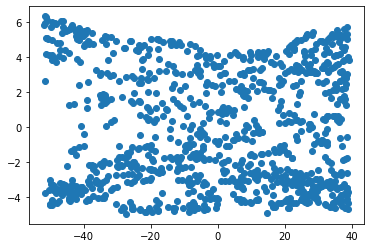

In [7]:
y = iso.transform(data, 2)
plt.scatter(y[:, 0], y[:, 1])
plt.show()


Since our own implementation of `FloydWarshall` takes some time, even if we used just in time compilation, we switch to `scipy.sparse.csgraph.shortest_path`. Let's try again the same thing but with 5000 points.

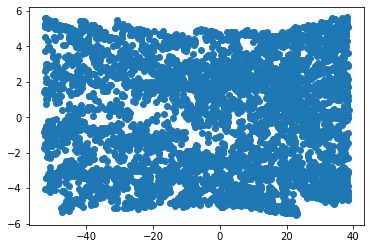

In [8]:
from scipy.sparse.csgraph import shortest_path

data = swiss_roll(5000)
iso = ISOMAP(n_neighbors=15, optimization_alg=shortest_path)
iso.fit(data)
y = iso.transform(data, 2)
plt.scatter(y[:, 0], y[:, 1])
plt.show()


Let's try noisy with some noise at different number of neighboors

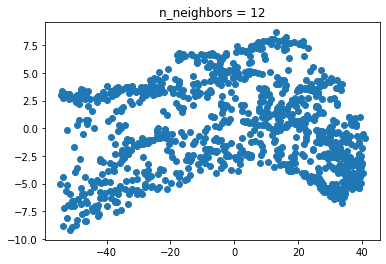

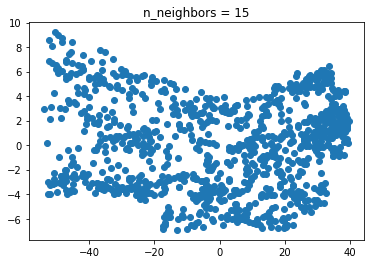

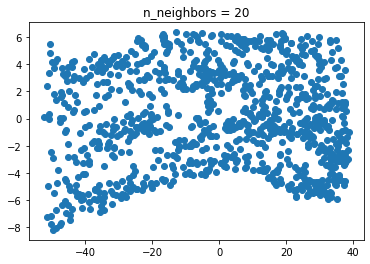

<Figure size 432x288 with 0 Axes>

In [18]:
data = swiss_roll(1000, noisy=True)

for n_neighbors in [12, 15, 20]:
    plt.title(f'n_neighbors = {n_neighbors}')
    iso = ISOMAP(n_neighbors=n_neighbors, optimization_alg=shortest_path)
    iso.fit(data)
    y = iso.transform(data, 2)
    plt.scatter(y[:, 0], y[:, 1])
    plt.show()
    plt.figure()



## Exercise 2

Let's first import the dataset

In [20]:
# get the dataframe
df = pd.read_excel('../Datasets/Dry_Bean_Dataset.xlsx')

# create matrix for data in numpy ndarray
y = df['Class']
X = df.drop('Class', axis=1)
encoder = OrdinalEncoder()
y = np.array(y)
encoder.fit(y.reshape(-1, 1))
y = encoder.transform(y.reshape(-1, 1))

# split to train and 
X, _, y, _ = train_test_split(X, y, train_size=1000)

# split train test set
X_train, X_test, target_train, target_test = train_test_split(X, y, test_size=0.2)

# normilize
X_train = (X_train - X_train.mean())/(X_train.std())
X_test = (X_test - X_test.mean())/X_test.std()
target_test = target_test.ravel()


Let's train the classifier

In [21]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

for numb_components in range(1, X.shape[1]+1):
    
    # training
    isomap = ISOMAP(n_neighbors=90, optimization_alg=shortest_path)
    isomap.fit(X_train) 
    y_train = isomap.transform(X_train, numb_components)
    model = LogisticRegression(multi_class='multinomial')
    model.fit(y_train, target_train)
    score_train = model.score(y_train, target_train)

    # testing
    isomap = ISOMAP(n_neighbors=90, optimization_alg=shortest_path)
    isomap.fit(X_test)
    y_test = isomap.transform(X_test, numb_components)
    score = model.score(y_test, target_test)

    print(
        f"Number of components: {numb_components} / Accuracy train: {score_train} / Accuracy test: {score}")


Number of components: 1 / Accuracy train: 0.60625 / Accuracy test: 0.11
Number of components: 2 / Accuracy train: 0.85 / Accuracy test: 0.105
Number of components: 3 / Accuracy train: 0.85375 / Accuracy test: 0.11
Number of components: 4 / Accuracy train: 0.855 / Accuracy test: 0.11
Number of components: 5 / Accuracy train: 0.875 / Accuracy test: 0.115
Number of components: 6 / Accuracy train: 0.905 / Accuracy test: 0.115
Number of components: 7 / Accuracy train: 0.90125 / Accuracy test: 0.105
Number of components: 8 / Accuracy train: 0.91125 / Accuracy test: 0.105
Number of components: 9 / Accuracy train: 0.91125 / Accuracy test: 0.11
Number of components: 10 / Accuracy train: 0.9125 / Accuracy test: 0.105
Number of components: 11 / Accuracy train: 0.9125 / Accuracy test: 0.105
Number of components: 12 / Accuracy train: 0.9225 / Accuracy test: 0.105
Number of components: 13 / Accuracy train: 0.91625 / Accuracy test: 0.115
Number of components: 14 / Accuracy train: 0.91875 / Accuracy t

As we can see the model hardly generalize, while the training accuracy is really high.